# **Install & Import Dependencies**

In [1]:
!pip install librosa soundfile wget -q
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd  # For playing audio in Colab

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T

import librosa
import librosa.display
import soundfile as sf

  Preparing metadata (setup.py) ... done


In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **Hyperparameters & Configuration**

In [15]:
class Config:
    # for Audio
    sample_rate     = 22050   # Standard sample rate for speech/music
    n_fft           = 1024    # FFT window size
    hop_length      = 256     # Frames between STFT columns → controls time resolution
    win_length      = 1024    # Window length for STFT
    n_mels          = 80      # Number of mel filterbank channels (MelGAN paper uses 80)
    segment_length  = 8192    # Audio samples per training chunk (~0.37 sec @ 22050 Hz)
    fmin            = 0.0     # Minimum frequency for mel filterbank
    fmax            = 8000.0  # Maximum frequency for mel filterbank


    #Model
    # Generator upsampling: mel frames → waveform samples
    # hop_length = product of upsample_rates → 256 = 8×8×4 (close enough, we use 8×8×4×1)
    upsample_rates        = [8, 8, 4]      # Each stage multiplies time dimension
    upsample_kernel_sizes = [16, 16, 8]   # Kernel size for each transposed conv
    upsample_initial_ch   = 512           # Channels after first conv (halved each stage)
    resblock_kernel_sizes = [3, 7, 11]    #  multiple receptive fields
    resblock_dilation_sizes = [[1,3,5], [1,3,5], [1,3,5]]  # Dilations per resblock

    #Training
    batch_size      = 16
    lr_g            = 1e-4    # Generator learning rate
    lr_d            = 1e-4    # Discriminator learning rate
    betas           = (0.5, 0.9)   # Adam betas
    n_epochs        = 50
    save_interval   = 20      # Save checkpoint every N epochs
    log_interval    = 10      # Print loss every N steps

cfg = Config()
print("Config loaded")

Config loaded


# **Dataset (LJSpeech)**

In [16]:
# LJSpeech: 13,100 short audio clips from a single speaker
# Download: https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

#Download & Extract
import os

DATA_DIR = "/content/LJSpeech-1.1"

if not os.path.exists(DATA_DIR):
    print("Downloading LJSpeech dataset (~2.6 GB)...")
    !wget -q --show-progress https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
    print("Extracting...")
    !tar -xjf LJSpeech-1.1.tar.bz2
    print("Done!")
else:
    print("Dataset already exists.")

# List a few files to verify
wav_files = [os.path.join(DATA_DIR, "wavs", f)
             for f in os.listdir(os.path.join(DATA_DIR, "wavs"))
             if f.endswith(".wav")]
print(f"Found {len(wav_files)} wav files")


# Mel-Spectrogram Transform
# This converts raw audio → mel spectrogram (conditioning input to MelGAN)
mel_transform = T.MelSpectrogram(
    sample_rate   = cfg.sample_rate,
    n_fft         = cfg.n_fft,
    win_length    = cfg.win_length,
    hop_length    = cfg.hop_length,
    f_min         = cfg.fmin,
    f_max         = cfg.fmax,
    n_mels        = cfg.n_mels,
    power         = 1.0,           # Amplitude spectrogram
).to(device)

def wav_to_mel(waveform):
    """
    Convert waveform tensor → log-mel spectrogram
    Input:  [B, 1, T]  (batch, channels, samples)
    Output: [B, 80, T_mel]  (batch, mel_bins, frames)
    """
    # mel_transform expects [B, T] or [B, 1, T]
    # but returns [B, 1, n_mels, T_mel] when input is [B, 1, T]
    # → we must squeeze the channel dim out

    waveform = waveform.squeeze(1)        # [B, 1, T] → [B, T]
    mel = mel_transform(waveform)         # [B, n_mels, T_mel]
    mel = torch.log(torch.clamp(mel, min=1e-5))
    return mel                            # [B, 80, T_mel]  ✅


#  Dataset Class
class LJSpeechDataset(Dataset):
    """
    Loads raw waveforms and computes mel spectrograms on the fly.
    Each item: a fixed-length audio segment + its corresponding mel spectrogram.
    """
    def __init__(self, wav_files, segment_length, sample_rate):
        self.wav_files      = wav_files
        self.segment_length = segment_length
        self.sample_rate    = sample_rate

    def __len__(self):
        return len(self.wav_files)

    def __getitem__(self, idx):
        path = self.wav_files[idx]

        # Load audio → resample if needed
        wav, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            wav = torchaudio.functional.resample(wav, sr, self.sample_rate)

        # Convert to mean
        wav = wav.mean(dim=0, keepdim=True)  # [1, T]

        # Pad or randomly crop to fixed segment length
        if wav.shape[1] < self.segment_length:
            pad = self.segment_length - wav.shape[1]
            wav = F.pad(wav, (0, pad))
        else:
            start = random.randint(0, wav.shape[1] - self.segment_length)
            wav = wav[:, start : start + self.segment_length]

        # Normalize audio to [-1, 1]
        wav = wav / (wav.abs().max() + 1e-8)

        return wav  # We compute mel in the training loop (on GPU)


#DataLoader
# 80% train, 20% validation split
random.shuffle(wav_files)
split      = int(0.8 * len(wav_files))
train_files = wav_files[:split]
val_files   = wav_files[split:]

train_dataset = LJSpeechDataset(train_files, cfg.segment_length, cfg.sample_rate)
val_dataset   = LJSpeechDataset(val_files,   cfg.segment_length, cfg.sample_rate)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size,
                          shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=4,
                          shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")
print(f"Train batches: {len(train_loader)}")

Dataset already exists.
Found 13100 wav files
Train: 10480 | Val: 2620
Train batches: 655


In [17]:
# MelGAN Generator
# Architecture: Mel → Waveform
#
#  Input: Mel spectrogram [B, 80, T_mel]
#   Conv1d (80 → 512)
#   Upsample Block × 3 (TransposedConv + MRF ResBlocks)
#   Conv1d (→ 1)  + Tanh
#  Output: Waveform [B, 1, T_audio]   where T_audio = T_mel × hop_length
#
# KEY DESIGN CHOICES:
#   Transposed convolutions for upsampling (learned upsampling)
#    Multi-Receptive Field Fusion (MRF): parallel dilated convolutions
#    capture both fine and coarse temporal patterns simultaneously
#    Weight normalization (not batch norm) → stable for sequence models
#    Tanh output → bounded in [-1, 1] like real audio


class ResBlock(nn.Module):
    """
    Multi-Receptive Field (MRF) Residual Block.
    Uses dilated convolutions with different dilation rates in parallel
    to capture patterns at multiple time scales.
    """
    def __init__(self, channels, kernel_size, dilation_sizes):
        super().__init__()
        # Stack of dilated conv layers — each dilation "zooms out" in time
        self.convs = nn.ModuleList()
        for d in dilation_sizes:
            padding = (kernel_size * d - d) // 2  # Same padding
            self.convs.append(
                nn.utils.weight_norm(
                    nn.Conv1d(channels, channels,
                              kernel_size, dilation=d, padding=padding)
                )
            )

    def forward(self, x):
        # Residual: sum of all dilated conv outputs + skip connection
        out = x
        for conv in self.convs:
            out = out + conv(F.leaky_relu(out, 0.1))
        return out


class MRFBlock(nn.Module):
    """
    Multi-Receptive Field Fusion:
    Runs multiple ResBlocks with DIFFERENT kernel sizes in parallel,
    then averages their outputs.
    This is the core innovation in MelGAN's generator.
    """
    def __init__(self, channels, kernel_sizes, dilation_sizes):
        super().__init__()
        self.resblocks = nn.ModuleList([
            ResBlock(channels, k, d)
            for k, d in zip(kernel_sizes, dilation_sizes)
        ])

    def forward(self, x):
        # Average over all receptive field branches
        out = sum(rb(x) for rb in self.resblocks) / len(self.resblocks)
        return out


class Generator(nn.Module):
    """
    MelGAN Generator:
    Progressively upsamples mel spectrogram to full waveform using
    transposed convolutions + MRF residual blocks.
    """
    def __init__(self, cfg):
        super().__init__()

        #  Initial projection: 80 mel channels → 512 channels
        self.pre_conv = nn.utils.weight_norm(
            nn.Conv1d(cfg.n_mels, cfg.upsample_initial_ch, kernel_size=7, padding=3)
        )

        #  Upsampling stages
        self.upsample_blocks = nn.ModuleList()
        self.mrf_blocks      = nn.ModuleList()

        ch = cfg.upsample_initial_ch
        for i, (up_rate, up_kernel) in enumerate(
                zip(cfg.upsample_rates, cfg.upsample_kernel_sizes)):

            # Transposed conv: doubles/quadruples the time dimension
            # Channels halve at each stage: 512→256→128→64
            self.upsample_blocks.append(
                nn.utils.weight_norm(
                    nn.ConvTranspose1d(
                        ch, ch // 2,
                        kernel_size = up_kernel,
                        stride      = up_rate,
                        padding     = (up_kernel - up_rate) // 2  # No artifacts
                    )
                )
            )
            ch //= 2

            # MRF block after each upsampling stage
            self.mrf_blocks.append(
                MRFBlock(ch, cfg.resblock_kernel_sizes, cfg.resblock_dilation_sizes)
            )

        #  Output projection: channels → 1 (mono waveform)
        self.post_conv = nn.utils.weight_norm(
            nn.Conv1d(ch, 1, kernel_size=7, padding=3)
        )

    def forward(self, mel):
        """
        mel: [B, n_mels, T_mel]
        returns: [B, 1, T_audio]
        """
        x = self.pre_conv(mel)

        for up, mrf in zip(self.upsample_blocks, self.mrf_blocks):
            x = F.leaky_relu(x, 0.1)
            x = up(x)       # Upsample in time
            x = mrf(x)      # Refine with MRF

        x = F.leaky_relu(x, 0.1)
        x = self.post_conv(x)
        x = torch.tanh(x)   # Bound output to [-1, 1]
        return x


G = Generator(cfg).to(device)
test_mel = torch.randn(2, cfg.n_mels, 32).to(device)  # [B, 80, T_mel]
test_out = G(test_mel)
print(f" Generator output shape: {test_out.shape}")  # Expected: [2, 1, ~1024]
total_params = sum(p.numel() for p in G.parameters())
print(f"Generator parameters: {total_params:,}")

 Generator output shape: torch.Size([2, 1, 8192])
Generator parameters: 8,403,586


In [18]:
# MelGAN Discriminator — Multi-Scale Discriminator (MSD)
# KEY DESIGN CHOICE: Multi-Scale Discriminator
#   MelGAN uses MULTIPLE discriminators operating on different
#   audio resolutions (raw, 2x downsampled, 4x downsampled).
#   This forces the generator to produce realistic audio at
#   multiple time scales (fine detail + global structure).
#
# Each sub-discriminator is a stack of grouped convolutions
# with increasing dilation → large receptive field efficiently.


class SubDiscriminator(nn.Module):
    """
    A single scale discriminator.
    Stack of Conv1d layers with increasing dilation.
    Uses Grouped convolutions (like depthwise) for efficiency.
    Returns: list of feature maps (used for Feature Matching Loss)
    """
    def __init__(self):
        super().__init__()

        # Each conv: (in_ch, out_ch, kernel, stride, padding, groups)
        # groups > 1 → grouped convolution (paper uses groups=4 for efficiency)
        conv_configs = [
            (1,   16,  15, 1, 7,   1),
            (16,  64,  41, 4, 20,  4),
            (64,  256, 41, 4, 20,  16),
            (256, 1024,41, 4, 20,  64),
            (1024,1024,41, 4, 20,  256),
            (1024,1024,5,  1, 2,   1),
        ]

        self.convs = nn.ModuleList()
        for (ci, co, k, s, p, g) in conv_configs:
            self.convs.append(
                nn.utils.weight_norm(
                    nn.Conv1d(ci, co, k, stride=s, padding=p, groups=g)
                )
            )

        # Final output: 1 value per time step (real/fake score)
        self.final_conv = nn.utils.weight_norm(
            nn.Conv1d(1024, 1, 3, padding=1)
        )

    def forward(self, x):
        """
        x: [B, 1, T]
        Returns:
          - final score: [B, 1, T']
          - feature_maps: list of intermediate activations (for Feature Matching Loss)
        """
        feature_maps = []
        for conv in self.convs:
            x = F.leaky_relu(conv(x), 0.2)
            feature_maps.append(x)
        x = self.final_conv(x)
        feature_maps.append(x)
        return x, feature_maps


class MultiScaleDiscriminator(nn.Module):
    """
    Multi-Scale Discriminator (MSD):
    3 sub-discriminators on different resolutions.
    Downsampling done with AvgPool1d (anti-aliased strided downsampling).
    """
    def __init__(self):
        super().__init__()
        self.discriminators = nn.ModuleList([
            SubDiscriminator(),   # Scale 1: original audio
            SubDiscriminator(),   # Scale 2: 2× downsampled
            SubDiscriminator(),   # Scale 3: 4× downsampled
        ])
        # Average pooling for downsampling (mimics lowpass + downsample)
        self.pooling = nn.AvgPool1d(kernel_size=4, stride=2, padding=2)

    def forward(self, x):
        """
        x: [B, 1, T]
        Returns:
          - scores: list of score tensors from each sub-discriminator
          - feature_maps_all: list of feature map lists
        """
        scores        = []
        feature_maps_all = []

        for i, disc in enumerate(self.discriminators):
            score, fmaps = disc(x)
            scores.append(score)
            feature_maps_all.append(fmaps)
            x = self.pooling(x)   # Downsample for next discriminator

        return scores, feature_maps_all


D = MultiScaleDiscriminator().to(device)
test_wav = torch.randn(2, 1, 8192).to(device)
scores, fmaps = D(test_wav)
print(f"Discriminator scales: {len(scores)}")
for i, s in enumerate(scores):
    print(f"   Scale {i+1} score shape: {s.shape}")
total_params_d = sum(p.numel() for p in D.parameters())
print(f"Discriminator parameters: {total_params_d:,}")

Discriminator scales: 3
   Scale 1 score shape: torch.Size([2, 1, 32])
   Scale 2 score shape: torch.Size([2, 1, 17])
   Scale 3 score shape: torch.Size([2, 1, 9])
Discriminator parameters: 16,924,086


In [19]:
#  Loss Functions
# MelGAN uses TWO losses for the generator:
#
# 1. Adversarial Loss (LSGAN):
#    Least-Squares GAN loss instead of binary cross-entropy.
#    More stable training, no vanishing gradients.
#    G wants D(G(mel)) ≈ 1 (fool discriminator)
#    D wants D(real) ≈ 1, D(fake) ≈ 0
#
# 2. Feature Matching Loss:
#    L1 distance between real and fake feature maps inside D.
#    Acts as a "perceptual loss" — makes generated audio
#    match real audio in the discriminator's learned feature space.
#    This is crucial for MelGAN quality — no mel reconstruction loss!


def discriminator_loss(real_scores, fake_scores):
    """
    LSGAN Discriminator loss:
    D wants real → 1, fake → 0
    Loss = mean((D(real) - 1)²) + mean(D(fake)²)
    """
    loss = 0.0
    for real, fake in zip(real_scores, fake_scores):
        loss += torch.mean((real - 1.0) ** 2)   # Real should be 1
        loss += torch.mean(fake ** 2)            # Fake should be 0
    return loss


def generator_adversarial_loss(fake_scores):
    """
    LSGAN Generator adversarial loss:
    G wants D(fake) → 1 (fool D)
    Loss = mean((D(fake) - 1)²)
    """
    loss = 0.0
    for fake in fake_scores:
        loss += torch.mean((fake - 1.0) ** 2)
    return loss


def feature_matching_loss(real_fmaps, fake_fmaps, weight=10.0):
    """
    Feature Matching Loss:
    L1 distance between intermediate feature maps of D for real vs fake.
    This guides the generator to match fine-grained audio structure.
    weight=10 as used in the original MelGAN paper.
    """
    loss = 0.0
    for real_maps, fake_maps in zip(real_fmaps, fake_fmaps):
        for r, f in zip(real_maps, fake_maps):
            loss += F.l1_loss(f, r.detach())  # detach real → no grad through D
    return weight * loss


print("Loss functions defined")
print("""
Loss Summary:
─────────────────────────────────────────────────
  D loss = LSGAN(real→1) + LSGAN(fake→0)
  G loss = LSGAN(fake→1) + λ·FeatureMatching
  λ = 10 (feature matching weight)
─────────────────────────────────────────────────
""")

Loss functions defined

Loss Summary:
─────────────────────────────────────────────────
  D loss = LSGAN(real→1) + LSGAN(fake→0)
  G loss = LSGAN(fake→1) + λ·FeatureMatching
  λ = 10 (feature matching weight)
─────────────────────────────────────────────────



In [20]:
# Training Loop

import time

#  Initialize models & optimizers
G = Generator(cfg).to(device)
D = MultiScaleDiscriminator().to(device)

opt_G = torch.optim.Adam(G.parameters(), lr=cfg.lr_g, betas=cfg.betas)
opt_D = torch.optim.Adam(D.parameters(), lr=cfg.lr_d, betas=cfg.betas)

# Learning rate schedulers: decay by 0.999 each epoch (keeps training stable)
sched_G = torch.optim.lr_scheduler.ExponentialLR(opt_G, gamma=0.999)
sched_D = torch.optim.lr_scheduler.ExponentialLR(opt_D, gamma=0.999)

#  History for plotting
history = {"G_loss": [], "D_loss": [], "FM_loss": []}

os.makedirs("/content/checkpoints", exist_ok=True)

print(" Starting Training...\n")

for epoch in range(1, cfg.n_epochs + 1):
    G.train(); D.train()
    epoch_G, epoch_D, epoch_FM = [], [], []
    t0 = time.time()

    for step, real_wav in enumerate(train_loader):
        real_wav = real_wav.to(device)   # [B, 1, T]

        #  Compute mel spectrogram (on GPU)
        with torch.no_grad():
            mel = wav_to_mel(real_wav)   # [B, 80, T_mel]

        #  Generate fake waveform
        fake_wav = G(mel)                # [B, 1, T_audio]

        # Align lengths (generator output might differ by a few samples)
        min_len  = min(real_wav.shape[-1], fake_wav.shape[-1])
        real_wav = real_wav[..., :min_len]
        fake_wav = fake_wav[..., :min_len]

        #  Train Discriminator
        opt_D.zero_grad()

        real_scores, real_fmaps = D(real_wav)
        fake_scores, _          = D(fake_wav.detach())  # detach: don't train G here

        loss_D = discriminator_loss(real_scores, fake_scores)
        loss_D.backward()
        opt_D.step()

        #  Train Generator
        opt_G.zero_grad()

        # Need fresh D forward pass with gradients flowing through G
        fake_scores, fake_fmaps = D(fake_wav)

        loss_adv = generator_adversarial_loss(fake_scores)
        loss_fm  = feature_matching_loss(real_fmaps, fake_fmaps, weight=10.0)
        loss_G   = loss_adv + loss_fm  # Total generator loss

        loss_G.backward()
        opt_G.step()

        #  Logging
        epoch_G.append(loss_G.item())
        epoch_D.append(loss_D.item())
        epoch_FM.append(loss_fm.item())

        if step % cfg.log_interval == 0:
            print(f"  Epoch {epoch:03d} | Step {step:04d}/{len(train_loader)} "
                  f"| D: {loss_D.item():.4f} "
                  f"| G: {loss_G.item():.4f} "
                  f"| FM: {loss_fm.item():.4f}")

    #  Epoch summary
    avg_G  = np.mean(epoch_G)
    avg_D  = np.mean(epoch_D)
    avg_FM = np.mean(epoch_FM)
    elapsed = time.time() - t0

    history["G_loss"].append(avg_G)
    history["D_loss"].append(avg_D)
    history["FM_loss"].append(avg_FM)

    sched_G.step()
    sched_D.step()

    print(f" Epoch {epoch:03d}/{cfg.n_epochs} | "
          f"D: {avg_D:.4f} | G: {avg_G:.4f} | FM: {avg_FM:.4f} | "
          f"Time: {elapsed:.1f}s")

    #  Save checkpoint
    if epoch % cfg.save_interval == 0:
        torch.save({
            "epoch":       epoch,
            "G_state":     G.state_dict(),
            "D_state":     D.state_dict(),
            "opt_G":       opt_G.state_dict(),
            "opt_D":       opt_D.state_dict(),
            "history":     history,
        }, f"/content/checkpoints/melgan_epoch{epoch:03d}.pt")
        print(f"Checkpoint saved at epoch {epoch}")

print("\n Training Complete!")

 Starting Training...

  Epoch 001 | Step 0000/655 | D: 2.9954 | G: 7.8221 | FM: 5.4352
  Epoch 001 | Step 0010/655 | D: 1.5368 | G: 2.9456 | FM: 2.0877
  Epoch 001 | Step 0020/655 | D: 1.4956 | G: 2.8515 | FM: 2.0522
  Epoch 001 | Step 0030/655 | D: 1.4775 | G: 4.0670 | FM: 3.2555
  Epoch 001 | Step 0040/655 | D: 1.3691 | G: 3.9860 | FM: 3.1859
  Epoch 001 | Step 0050/655 | D: 1.3141 | G: 4.7635 | FM: 3.9150
  Epoch 001 | Step 0060/655 | D: 1.6469 | G: 5.3654 | FM: 4.6160
  Epoch 001 | Step 0070/655 | D: 1.3789 | G: 5.3421 | FM: 4.5528
  Epoch 001 | Step 0080/655 | D: 1.2833 | G: 5.5943 | FM: 4.7319
  Epoch 001 | Step 0090/655 | D: 1.3045 | G: 6.5440 | FM: 5.8158
  Epoch 001 | Step 0100/655 | D: 1.4402 | G: 5.3999 | FM: 4.6491
  Epoch 001 | Step 0110/655 | D: 1.4000 | G: 6.3345 | FM: 5.4236
  Epoch 001 | Step 0120/655 | D: 1.3208 | G: 6.5377 | FM: 5.6092
  Epoch 001 | Step 0130/655 | D: 1.6358 | G: 6.9071 | FM: 6.2274
  Epoch 001 | Step 0140/655 | D: 1.5091 | G: 8.6606 | FM: 7.7407
  

In [ ]:
# Visualize Training Loss Curves

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("MelGAN Training Loss Curves", fontsize=16, fontweight='bold')

epochs_range = range(1, len(history["G_loss"]) + 1)

#  Generator Loss
axes[0].plot(epochs_range, history["G_loss"], color='royalblue', linewidth=2)
axes[0].set_title("Generator Loss (Adv + FM)", fontsize=13)
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].grid(True, alpha=0.3)

#  Discriminator Loss
axes[1].plot(epochs_range, history["D_loss"], color='crimson', linewidth=2)
axes[1].set_title("Discriminator Loss (LSGAN)", fontsize=13)
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Loss")
axes[1].grid(True, alpha=0.3)

#  Feature Matching Loss
axes[2].plot(epochs_range, history["FM_loss"], color='forestgreen', linewidth=2)
axes[2].set_title("Feature Matching Loss (×10)", fontsize=13)
axes[2].set_xlabel("Epoch"); axes[2].set_ylabel("Loss")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("/content/training_curves.png", dpi=150)
plt.show()
print("Loss curves saved.")

In [22]:
# Inference — Generate Audio from Mel Spectrogram

# SAMPLING / INFERENCE EXPLANATION:
#   MelGAN is a CONDITIONAL GAN — it doesn't sample random noise.
#   Instead, inference is DETERMINISTIC:
#     1. Take a real audio file (or synthesized mel from a TTS model)
#     2. Convert to log-mel spectrogram
#     3. Feed mel to Generator → get waveform
#   This is much faster than autoregressive vocoders (WaveNet etc.)
#   because it runs in a single forward pass (fully parallel).

G.eval()

def generate_audio(mel_spectrogram):
    """
    Run generator inference on a mel spectrogram.
    mel_spectrogram: [1, n_mels, T_mel] tensor
    Returns: numpy array of waveform samples
    """
    with torch.no_grad():
        fake_wav = G(mel_spectrogram.to(device))  # [1, 1, T]
    return fake_wav.squeeze().cpu().numpy()        # [T]


#  Pick a validation file
sample_path = val_files[0]
real_wav_np, sr = librosa.load(sample_path, sr=cfg.sample_rate, mono=True)

# Trim to a manageable length (first 3 seconds)
real_wav_np = real_wav_np[:cfg.sample_rate * 3]

# Convert to tensor → mel
real_wav_t = torch.FloatTensor(real_wav_np).unsqueeze(0).unsqueeze(0).to(device)
mel_input   = wav_to_mel(real_wav_t)   # [1, 80, T_mel]

# Generate reconstructed audio
generated_wav = generate_audio(mel_input)

print(f" Real audio length:      {len(real_wav_np)/cfg.sample_rate:.2f} sec")
print(f" Generated audio length: {len(generated_wav)/cfg.sample_rate:.2f} sec")

#  Save audio files
sf.write("/content/real_audio.wav",      real_wav_np,   cfg.sample_rate)
sf.write("/content/generated_audio.wav", generated_wav, cfg.sample_rate)
print(" Audio files saved.")

#  Play in Colab
print("\n REAL Audio:")
ipd.display(ipd.Audio(real_wav_np, rate=cfg.sample_rate))

print("\n GENERATED Audio (MelGAN):")
ipd.display(ipd.Audio(generated_wav, rate=cfg.sample_rate))

 Real audio length:      3.00 sec
 Generated audio length: 3.01 sec
 Audio files saved.

 REAL Audio:



 GENERATED Audio (MelGAN):


#### the audio is noisy a little because i didn't train the model sufficiently, i trained it for 50 epochs only, but i think it needs more than 50 for more accurate results, and the training for 50 epochs took 4 hours!!!

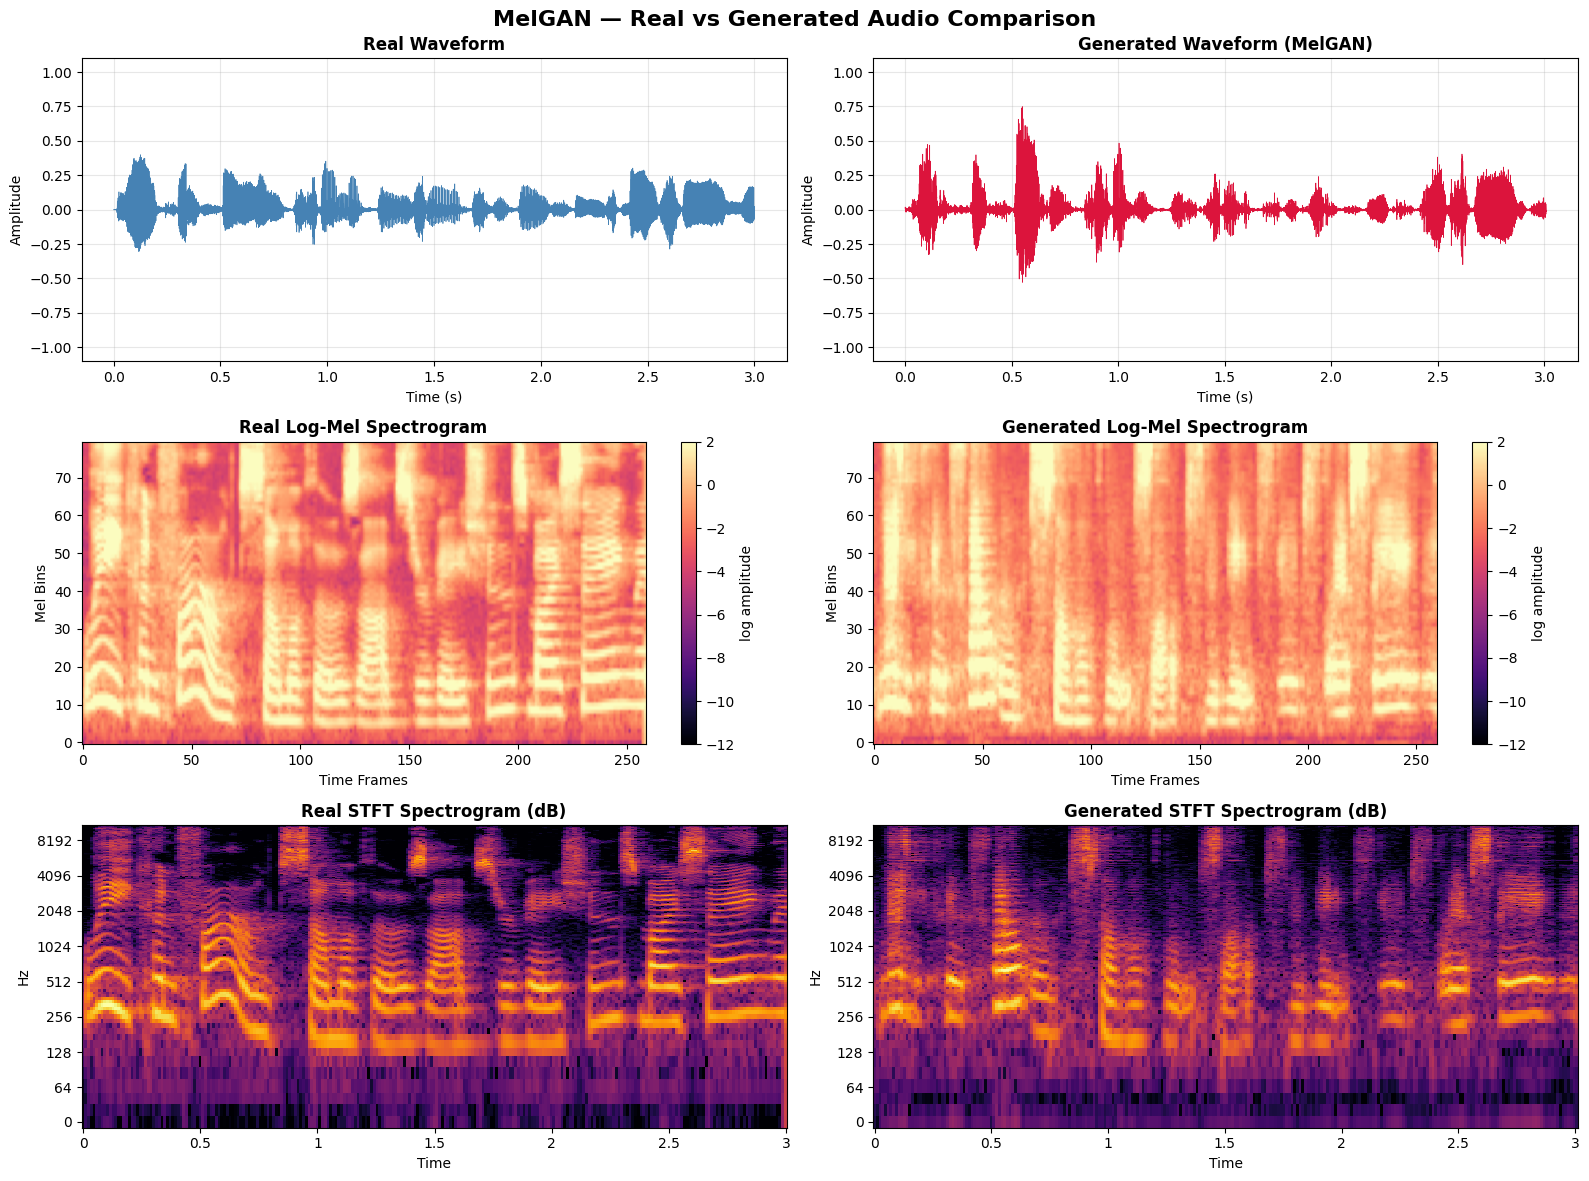

 Comparison visualization saved.


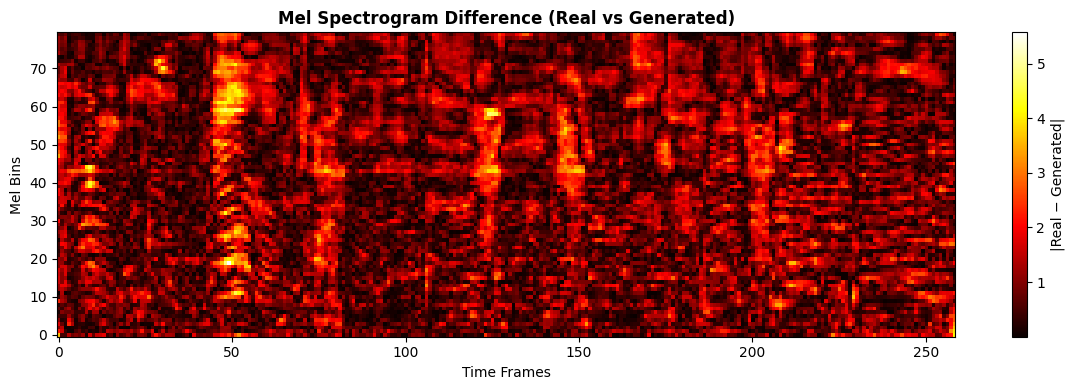

 Difference map saved.


In [23]:
#  Visualization — Spectrograms, Waveforms, Comparison

def compute_mel_numpy(wav_np):
    """Helper: compute mel spectrogram from numpy array."""
    t = torch.FloatTensor(wav_np).unsqueeze(0).unsqueeze(0).to(device)
    mel = wav_to_mel(t)
    return mel.squeeze().cpu().numpy()   # [80, T]

real_mel_np = compute_mel_numpy(real_wav_np)
gen_mel_np  = compute_mel_numpy(generated_wav)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle("MelGAN — Real vs Generated Audio Comparison", fontsize=16, fontweight='bold')

#  Row 1: Waveforms
t_real = np.linspace(0, len(real_wav_np)/cfg.sample_rate, len(real_wav_np))
t_gen  = np.linspace(0, len(generated_wav)/cfg.sample_rate, len(generated_wav))

axes[0,0].plot(t_real, real_wav_np, color='steelblue', linewidth=0.5)
axes[0,0].set_title("Real Waveform", fontweight='bold')
axes[0,0].set_xlabel("Time (s)"); axes[0,0].set_ylabel("Amplitude")
axes[0,0].set_ylim(-1.1, 1.1); axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(t_gen, generated_wav, color='crimson', linewidth=0.5)
axes[0,1].set_title("Generated Waveform (MelGAN)", fontweight='bold')
axes[0,1].set_xlabel("Time (s)"); axes[0,1].set_ylabel("Amplitude")
axes[0,1].set_ylim(-1.1, 1.1); axes[0,1].grid(True, alpha=0.3)

#  Row 2: Mel Spectrograms
im1 = axes[1,0].imshow(real_mel_np, aspect='auto', origin='lower',
                        cmap='magma', vmin=-12, vmax=2)
axes[1,0].set_title("Real Log-Mel Spectrogram", fontweight='bold')
axes[1,0].set_xlabel("Time Frames"); axes[1,0].set_ylabel("Mel Bins")
plt.colorbar(im1, ax=axes[1,0], label='log amplitude')

im2 = axes[1,1].imshow(gen_mel_np, aspect='auto', origin='lower',
                        cmap='magma', vmin=-12, vmax=2)
axes[1,1].set_title("Generated Log-Mel Spectrogram", fontweight='bold')
axes[1,1].set_xlabel("Time Frames"); axes[1,1].set_ylabel("Mel Bins")
plt.colorbar(im2, ax=axes[1,1], label='log amplitude')

#  Row 3: Linear Spectrograms (STFT)
D_real = librosa.amplitude_to_db(
    np.abs(librosa.stft(real_wav_np, n_fft=cfg.n_fft, hop_length=cfg.hop_length)), ref=np.max)
D_gen  = librosa.amplitude_to_db(
    np.abs(librosa.stft(generated_wav, n_fft=cfg.n_fft, hop_length=cfg.hop_length)), ref=np.max)

librosa.display.specshow(D_real, sr=cfg.sample_rate, hop_length=cfg.hop_length,
                         x_axis='time', y_axis='log', ax=axes[2,0], cmap='inferno')
axes[2,0].set_title("Real STFT Spectrogram (dB)", fontweight='bold')

librosa.display.specshow(D_gen, sr=cfg.sample_rate, hop_length=cfg.hop_length,
                         x_axis='time', y_axis='log', ax=axes[2,1], cmap='inferno')
axes[2,1].set_title("Generated STFT Spectrogram (dB)", fontweight='bold')

plt.tight_layout()
plt.savefig("/content/melgan_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(" Comparison visualization saved.")


#  Difference heatmap
min_t = min(real_mel_np.shape[1], gen_mel_np.shape[1])
diff  = np.abs(real_mel_np[:, :min_t] - gen_mel_np[:, :min_t])

plt.figure(figsize=(12, 4))
plt.imshow(diff, aspect='auto', origin='lower', cmap='hot')
plt.colorbar(label='|Real − Generated|')
plt.title("Mel Spectrogram Difference (Real vs Generated)", fontweight='bold')
plt.xlabel("Time Frames"); plt.ylabel("Mel Bins")
plt.tight_layout()
plt.savefig("/content/mel_difference.png", dpi=150)
plt.show()
print(" Difference map saved.")

In [24]:
# Save & Load — Checkpoint Management

def save_model(G, D, opt_G, opt_D, epoch, history, path):
    """Save full training state."""
    torch.save({
        "epoch":   epoch,
        "G":       G.state_dict(),
        "D":       D.state_dict(),
        "opt_G":   opt_G.state_dict(),
        "opt_D":   opt_D.state_dict(),
        "history": history,
        "cfg":     vars(cfg),
    }, path)
    print(f" Model saved → {path}")


def load_model(path, G, D, opt_G=None, opt_D=None):
    """Load from checkpoint."""
    ckpt = torch.load(path, map_location=device)
    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    if opt_G: opt_G.load_state_dict(ckpt["opt_G"])
    if opt_D: opt_D.load_state_dict(ckpt["opt_D"])
    print(f" Model loaded from {path} (epoch {ckpt['epoch']})")
    return ckpt.get("history", {}), ckpt["epoch"]


#  Save final model
save_model(G, D, opt_G, opt_D, cfg.n_epochs, history, "/content/melgan_final.pt")

#  To LOAD (e.g. in a new session):
# G = Generator(cfg).to(device)
# D = MultiScaleDiscriminator().to(device)
# history, start_epoch = load_model("/content/melgan_final.pt", G, D)

print("""
╔══════════════════════════════════════════════════════╗
║           MelGAN Implementation Complete!            ║
╠══════════════════════════════════════════════════════╣
║   Generator (Transposed Conv + MRF)                  ║
║   Multi-Scale Discriminator (3 scales)               ║
║   LSGAN + Feature Matching Loss                      ║
║   LJSpeech Dataset + DataLoader                      ║
║   Training Loop with Checkpoints                     ║
║   Inference (Mel → Waveform)                         ║
║   Visualizations (Waveform, Mel, STFT, Diff)         ║
║   Audio Playback in Colab                            ║
╚══════════════════════════════════════════════════════╝
""")

 Model saved → /content/melgan_final.pt

╔══════════════════════════════════════════════════════╗
║           MelGAN Implementation Complete!            ║
╠══════════════════════════════════════════════════════╣
║   Generator (Transposed Conv + MRF)                  ║
║   Multi-Scale Discriminator (3 scales)               ║
║   LSGAN + Feature Matching Loss                      ║ 
║   LJSpeech Dataset + DataLoader                      ║
║   Training Loop with Checkpoints                     ║
║   Inference (Mel → Waveform)                         ║
║   Visualizations (Waveform, Mel, STFT, Diff)         ║
║   Audio Playback in Colab                            ║
╚══════════════════════════════════════════════════════╝



In [ ]:
""" Architecture Summary (Quick Reference)
INPUT: Log-Mel Spectrogram [B, 80, T_mel]
          ↓
    Conv1d (80→512, k=7)
          ↓
  ┌─────────────────────────┐
  │ Upsample Block ×3       │
  │  TransposedConv (÷2 ch) │  ← Doubles time dimension
  │  MRF Block              │  ← 3 parallel dilated ResBlocks
  └─────────────────────────┘
          ↓
    Conv1d (ch→1, k=7)
          ↓
        Tanh
          ↓
OUTPUT: Waveform [B, 1, T_audio]   T_audio = T_mel × 256

DISCRIMINATOR: 3× SubDiscriminator on [1x, 2x, 4x] downsampled audio
LOSS G:  LSGAN_adv + 10 × FeatureMatching
LOSS D:  LSGAN(real→1) + LSGAN(fake→0)"""